Before starting the mining process, please download the corpus from https://www.cs.cmu.edu/~jwieting/  

In [1]:
fn = '/home/dale/data/paraphrase_corpora/para-nmt-50m/para-nmt-50m.txt'

In [2]:
import pandas as pd
import numpy as np
import csv
pd.options.display.max_colwidth = 150

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [77]:
df = pd.read_csv(fn, sep='\t', header=None, nrows=1_000_000, encoding='utf-8', quoting=csv.QUOTE_NONE).dropna()
df.columns = ['reference', 'translation', 'similarity']

In [78]:
def lenth_diff(row):
    l1 = len(row.reference)
    l2 = len(row.translation)
    return np.abs(l1-l2) / (max(l1, l2) + 1)

df['lenght_diff'] = df.apply(lenth_diff, axis=1)

In [87]:
print(np.mean((df.similarity > 0.6)))
print(np.mean(df.similarity <= 0.95))
print(np.mean(df.lenght_diff <= 0.4))
print(np.mean((df.similarity > 0.6) & (df.similarity <= 0.95) & (df.lenght_diff <= 0.4)))

0.7133114266228533
0.8754667509335019
0.8481736963473927
0.5371920743841487


In [88]:
nonsim = df[(df.similarity > 0.6) & (df.similarity <= 0.95) & (df.lenght_diff <= 0.4)].head(1000)
nonsim.shape

(1000, 4)

In [92]:
from tqdm.auto import tqdm, trange
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

In [ ]:
model_name = 'SkolkovoInstitute/roberta_toxicity_classifier_v1'

tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)


def classify_preds(preds, batch_size=32, soft=True, threshold=0.5, soft=False):
    single = False
    if isinstance(preds, str):
        preds = [preds]
        single = True
    results = []
    
    f = trange if verbose else range

    for i in f(0, len(preds), batch_size)):
        batch = tokenizer(preds[i:i + batch_size], return_tensors='pt', padding=True)
        with torch.inference_mode():
            logits = model(**batch).logits
        if soft:
            result = torch.softmax(logits, -1)[:, 1].cpu().numpy()
        else:
            result = (logits[:, 1] > threshold).cpu().numpy()
        results.extend([1 - item for item in result])
    if single:
        return np.mean(results)
    return results

In [111]:
nonsim['ref_tox'] = classify_preds(nonsim.reference.tolist(), verbose=True, batch_size=64)
nonsim['trn_tox'] = classify_preds(nonsim.translation.tolist(), verbose=True, batch_size=64)

/home/dale/p3/lib/python3.7/site-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


/home/dale/p3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/home/dale/p3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

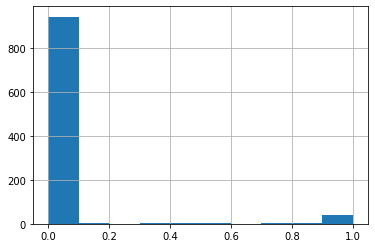

In [95]:
nonsim.trn_tox.hist()

* We filter sentences with moderate similarity (60% to 95%) and similar length (no more then 40% difference) - 50%% of corpus
* Out of them, 2% have estimated toxicity is very different between the source and the translation (20 out of 1000)
* Out of these 18:
    * 2 are false paraphrases
    * 8 in fact have comparable toxicity
    * 10 are valid detoxifications

In [99]:
fltr = np.abs(nonsim.trn_tox-nonsim.ref_tox) > 0.5
print(np.mean(fltr))
print(np.sum(fltr))

0.02
20


In [100]:
pd.options.display.max_colwidth = 500

In [101]:
nonsim[fltr].reset_index(drop=True)

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, that explains the high level of neurotransmitters.","if Alkar floods her with her mental waste, it would explain the high levels of neurotransmitter.",0.785171,0.010309,0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
5,I'm not gonna have a child... ...with the same genetic disorder as me who's gonna die. L...,I'm not going to breed kids with a genetic disorder that makes them die.,0.703185,0.206522,0.950956,0.035846
6,"They're all laughing at us, so we'll kick your ass.",they're laughing at us. We'll show you.,0.618866,0.230769,0.999492,0.000131
7,Maine was very short on black people back then.,there wasn't much black in Maine then.,0.720482,0.187500,0.963680,0.148710
8,"Briggs, what the hell's happening?","Briggs, what the hell is going on?",0.920373,0.000000,0.159096,0.841071
9,"Another one simply had no clue what to do, so whenever he met my brother he'd beat the crap out of him, and then say:","another simply didn't know what to do, so whenever he met my brother, he nearly beat the shit out of him.",0.877540,0.101695,0.055371,0.930472


# Large scale fine tuning

In [102]:
chunksize = 3_000

In [ ]:
df = pd.read_csv(fn, sep='\t', header=None, nrows=1_000_000, encoding='utf-8', quoting=csv.QUOTE_NONE).dropna()
df.columns = ['reference', 'translation', 'similarity']

In [123]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



* 50M / 3K = 16K iterations
* with 1 minute/iteration, the job will take 11 days, but with free GPUs this is faster

In [ ]:
results = []

for i, chunk in enumerate(tqdm(pd.read_csv(fn, sep='\t', header=None, encoding='utf-8', quoting=csv.QUOTE_NONE, chunksize=chunksize))):
    chunk.dropna(inplace=True)
    chunk.columns = ['reference', 'translation', 'similarity']
    chunk['lenght_diff'] = chunk.apply(lenth_diff, axis=1)
    nonsim = chunk[(chunk.similarity > 0.6) & (chunk.similarity <= 0.95) & (chunk.lenght_diff <= 0.4)].copy()
    
    nonsim['ref_tox'] = classify_preds(nonsim.reference.tolist(), verbose=False, batch_size=64)
    nonsim['trn_tox'] = classify_preds(nonsim.translation.tolist(), verbose=False, batch_size=64)
    
    fltr = np.abs(nonsim.trn_tox-nonsim.ref_tox) > 0.5
    mined = nonsim[fltr]
    results.append(mined)
    # print(nonsim.shape[0], mined.shape[0])
    if i > 0 and i % 10 == 0:
        res_df = pd.concat(results, ignore_index=True)
        print(res_df.shape[0], 'samples')
        res_df.to_csv('filtered.tsv', sep='\t', encoding='utf-8')

380 samples
689 samples
1025 samples
1353 samples
1663 samples
2012 samples
2353 samples
2696 samples
3033 samples
3372 samples
3709 samples
4040 samples
4385 samples
4702 samples
5046 samples
5405 samples
5742 samples
6046 samples
6374 samples
6698 samples
7042 samples
7386 samples
7718 samples
8015 samples
8374 samples
8679 samples
9031 samples
9371 samples
9735 samples
10066 samples
10385 samples
10728 samples
11046 samples
11395 samples
11748 samples
12081 samples
12414 samples


In [127]:
1

1

In [128]:
1

1

In [129]:
res_df = pd.concat(results, ignore_index=True)
res_df.shape

(577988, 6)

In [130]:
res_df.describe()

,similarity,lenght_diff,ref_tox,trn_tox
count,577988.000000,577988.000000,577988.000000,577988.000000
mean,0.758466,0.157654,0.541382,0.434479
std,0.092696,0.108056,0.457569,0.458904
min,0.600001,0.000000,0.000033,0.000033
25%,0.681099,0.066667,0.012172,0.000707
50%,0.754436,0.141818,0.806834,0.085110
75%,0.831241,0.238095,0.990469,0.973742
max,0.950000,0.400000,0.999724,0.999730


In [131]:
res_df.sample(10)

,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
88294,I just beat up three guys by myself.,I just cut three big men.,0.685685,0.297297,0.750938,0.005162
402968,"Whoo! Welcome back, mad dog!","welcome back, Fury!",0.735353,0.310345,0.998412,0.000081
396420,The roof is scraping my nut!,the roof is cutting off my balls!,0.746109,0.147059,0.012407,0.993682
344928,Blasted fairy music.,to hell with the music.,0.667527,0.125000,0.001486,0.932651
57239,"A kidnapper and a child murderer, yes.","the kidnapper and the child killer, yes.",0.888592,0.048780,0.967770,0.121575
444506,"For awhile, I went to sex clubs.",I went to sex clubs for a while.,0.923540,0.000000,0.147675,0.966582
22691,When I released her she bites you.,"if I leave her, she'll bite you.",0.675012,0.057143,0.006479,0.979373
242403,"If you don't at least try, Alex, you're already a loser.","if you don't try, Alex, you lost in advance.",0.727835,0.210526,0.998164,0.000176
179191,'I know you're only the humorous thugs.,"""I'm sure you're only a couple of comic thieves.",0.621704,0.183673,0.924046,0.265508
541902,You know as well as I do what a monster he was.,you know as much as I did for the monster.,0.700937,0.104167,0.995559,0.002968


<AxesSubplot:>

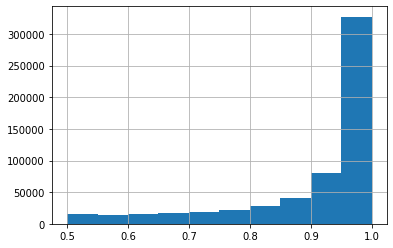

In [132]:
res_df['tox_diff'] = np.abs(res_df.ref_tox - res_df.trn_tox)
res_df.tox_diff.hist()